In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
car = pd.read_csv('toyota.csv')

### Data Visualization

<AxesSubplot:>

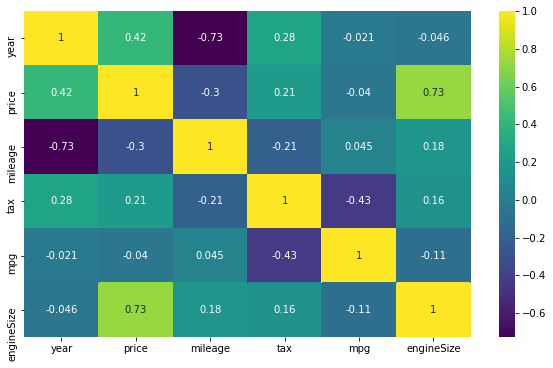

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(car.corr(), annot=True, cmap='viridis')

In [4]:
car.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


<AxesSubplot:xlabel='transmission', ylabel='price'>

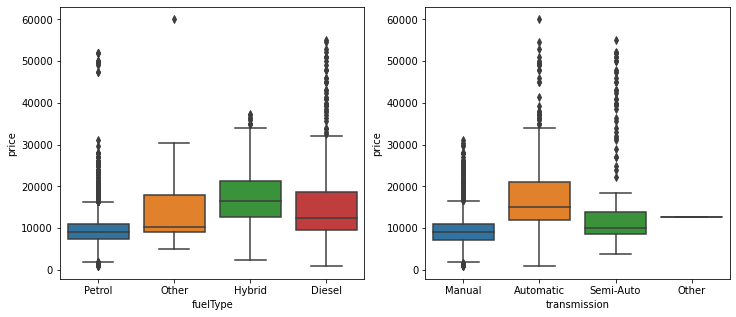

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(x='fuelType', y='price', data=car, ax=ax[0])
sns.boxplot(x='transmission', y='price', data=car, ax=ax[1])

<AxesSubplot:xlabel='year', ylabel='price'>

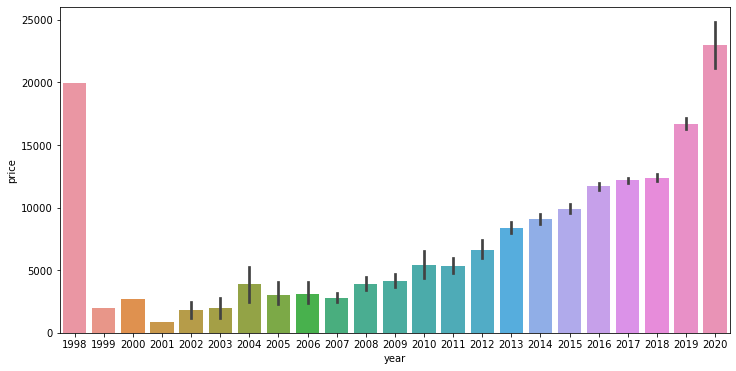

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='price', data=car)

Text(0.5, 1.0, 'Price Distribution')

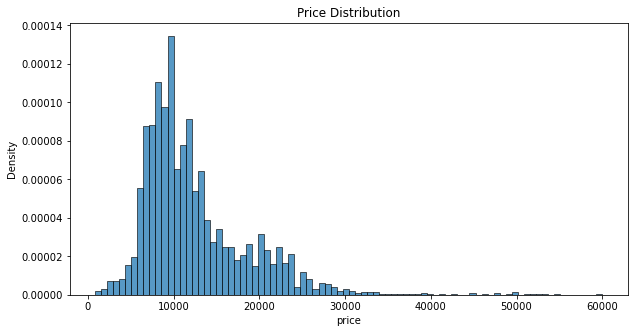

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(x='price', data=car, stat='density')
plt.title('Price Distribution')

In [8]:
num_vars = car.select_dtypes(exclude='object').columns.tolist()
cat_vars = car.select_dtypes(include='object').columns.tolist()

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
catdf = pd.DataFrame(ohe.fit_transform(car[cat_vars]))
numdf = car[num_vars]
cardf = pd.concat([numdf, catdf], axis=1)

### Data Training

**Splitting data set and use Isoforest to detect and eliminate outliers**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

X = cardf.drop(['price','tax'], axis=1)
y = cardf['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# IsoForest 
iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(X_train)

# Outliers will have -1 value. Choosing the good data points
outlier_set = np.where(outliers == -1)
index_list = outlier_set[0].tolist()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [11]:
# Drop the outliers
X_train_no = X_train.drop(index=index_list)
y_train_no = y_train.drop(index=index_list)

**LinearRegression Model**

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def LR_model(X, y):
    model_LR = LinearRegression()
    model_LR.fit(X, y)
    predictions_LR = model_LR.predict(X_test)
    return predictions_LR

**RandomForestRegressor Model**

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def rfr(X, y):
    model_rfr = RandomForestRegressor()
    param = {'n_estimators': [200, 400, 600]}
    grid = GridSearchCV(model_rfr, param_grid=param, cv=4, verbose=3, scoring='r2')
    grid.fit(X, y)
    return grid.predict(X_test)

### Model Evaluation

In [14]:
def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

In [15]:
preds_LR = LR_model(X_train, y_train)
preds_ouLR = LR_model(X_train_no, y_train_no)
preds_rfr = rfr(X_train, y_train)
preds_ourfr = rfr(X_train_no, y_train_no)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END ...............................n_estimators=200; total time=   2.7s
[CV 2/4] END ...............................n_estimators=200; total time=   2.5s
[CV 3/4] END ...............................n_estimators=200; total time=   2.7s
[CV 4/4] END ...............................n_estimators=200; total time=   2.5s
[CV 1/4] END ...............................n_estimators=400; total time=   4.8s
[CV 2/4] END ...............................n_estimators=400; total time=   4.9s
[CV 3/4] END ...............................n_estimators=400; total time=   4.8s
[CV 4/4] END ...............................n_estimators=400; total time=   4.8s
[CV 1/4] END ...............................n_estimators=600; total time=   7.9s
[CV 2/4] END ...............................n_estimators=600; total time=   7.9s
[CV 3/4] END ...............................n_estimators=600; total time=   7.6s
[CV 4/4] END ...............................n_est

In [16]:
predictions = [preds_LR, preds_ouLR, preds_rfr, preds_ourfr]

In [17]:
RMSE = []
r2 = []
for i in predictions:
    RMSE.append(np.round(rmse(y_test, i), 2))
    r2.append(np.round(r2_score(y_test, i), 3))

In [18]:
title = ['LR outliers', 'LR no outliers', 'RF outliers', 'RF no outliers']
score_df = pd.DataFrame({'RMSE': RMSE, 'R2': r2}, index=title)
score_df

,RMSE,R2
LR outliers,1721.75,0.926
LR no outliers,2828.13,0.800
RF outliers,1225.53,0.963
RF no outliers,2153.91,0.884


**Comments:** The model without the outliers removed performs better in both model regressor. This indicates that these outliers are significant, hence it would not be a good choice to eliminate them. The RandomForestRegressor model is chosen over the LinearRegression since it performs better with better RMSE and R2 scores. The RMSE of RF model is 1225.53, which is considered ok error for the car price.

*Check the assumption of prediction error*

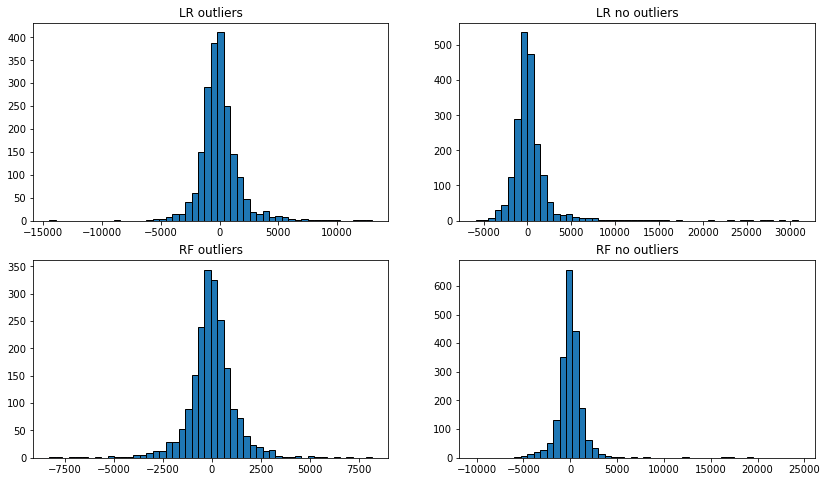

In [19]:
# RandomForest Model
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
z = 0
for i in range(2):
    for j in range(2):
        ax[i, j].hist(y_test-predictions[z], ec='black', bins=50)
        ax[i, j].set_title(title[z])
        z += 1

The error seems to follow normal distribution in all four cases